# Image Segmentation Model Implementation

This notebook implements an image segmentation model using Keras that:
- Works on AMD GPU, NVIDIA GPU, and CPU
- Uses Python 3.13 and FiftyOne for dataset management
- Includes 3+ segmentation classes
- Properly splits data into training and testing sets
- Calculates Dice, Micro-F1, and Macro-F1 metrics
- Visualizes training progress and results
- Presents a confusion matrix and additional metrics

## 1. Setup and Environment Configuration

In [1]:
!conda create -n tensorflow python=3.10 -c conda-forge -y

# activate & install the rest

!conda install keras matplotlib pycocotools sklearn scikit-learn seaborn pillow fiftyone -c conda-forge -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/hubertas/.conda/envs/tensorflow

  added / updated specs:
    - python=3.10


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge 
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-2_gnu 
  bzip2              conda-forge/linux-64::bzip2-1.0.8-h4bc722e_7 
  ca-certificates    conda-forge/noarch::ca-certificates-2025.4.26-hbd8a1cb_0 
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.43-h712a8e2_4 
  libexpat           conda-forge/linux-64::libexpat-2.7.0-h5888daf_0 
  libffi             conda-forge/linux-64::libffi-3.4.6-h2dba641_1 
  libgcc             conda-forge/linux-64::libgcc-14.2.0-h767d61c_2 
  libgcc-ng          conda-forge/linux-64::libgcc-ng-14.2.0-h69a702a_2 
  libgomp            conda-forge/linux-64::libgomp-14.2.0-h767d61c_2 
  liblzma            conda-forge/linux-6

In [1]:
import os, shutil, glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)

# Check if TensorFlow is built with ROCm support
print("Is GPU available? ", tf.test.is_gpu_available())
print("GPUs visible to TF:       ", tf.config.list_physical_devices("GPU"))


2025-04-26 22:10:18.002644: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 22:10:18.297177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 22:10:19.877557: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available?  False
GPUs visible to TF:        []


2025-04-26 22:10:22.052746: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


In [3]:
classes = ["Person", "Dog", "Car"]
num_classes = len(classes)
img_size = (256, 256)
AUTOTUNE    = tf.data.AUTOTUNE
BATCH_SIZE  = 8
BUFFER_SIZE = 1000
IMG_SIZE    = (256, 256)
NUM_CLASSES = len(classes) + 1

In [4]:
import logging
import fiftyone.core.logging as flog

flog.init_logging()
flog.set_logging_level(logging.DEBUG)

### Dataset Splitting & Export
Create train/val/test splits with image-mask pairs:

In [ ]:
fo.delete_dataset("open-images-v7-val-with-segs")
print(fo.list_datasets())
classes = ["Banana", "Orange", "Strawberry"]
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["segmentations"],
    classes=classes,
    max_samples=3_000,
    shuffle=True,
    only_matching=True,
    dataset_name="open-images-v7-val-with-segs",
)

# Create directory structure
dataset_dir = "./content"
shutil.rmtree("./content", ignore_errors=True)
for split in ["train", "val", "test"]:
    os.makedirs(f"{dataset_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{dataset_dir}/{split}/masks", exist_ok=True)


view      = dataset.shuffle(seed=51)
split_train = int(len(view) * 0.7)
split_val   = int(len(view) * 0.15)
split_test   = int(len(view) * 0.15)
train_v   = view.limit(split_train)
val_v     = view.skip(split_train).limit(split_val)
test_v    = view.skip(split_train + split_val).limit(150)

# Export splits
for split, samples in zip(["train", "val", "test"], [train_v, val_v, test_v]):
    samples.export(
        export_dir=f"{dataset_dir}/{split}",
        dataset_type=fo.types.ImageSegmentationDirectory,
        label_field="segmentations",
        overwrite=True,
    )

['open-images-v7-validation-3000']
Only found 93 (<3000) samples matching your requirements
Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v7' split 'validation'
 100% |███████████████████| 93/93 [4.6s elapsed, 0s remaining, 22.0 samples/s]      
Dataset 'open-images-v7-val-with-segs' created
OrderedDict({'id': <fiftyone.core.fields.ObjectIdField object at 0x7f542684dd10>, 'filepath': <fiftyone.core.fields.StringField object at 0x7f542684de50>, 'tags': <fiftyone.core.fields.ListField object at 0x7f542684ed50>, 'metadata': <fiftyone.core.fields.EmbeddedDocumentField object at 0x7f542684e350>, 'created_at': <fiftyone.core.fields.DateTimeField object at 0x7f542684e990>, 'last_modified_at': <fiftyone.core.fields.DateTimeField object at 0x7f542684ead0>, 'ground_truth': <fiftyone.core.fields.EmbeddedDocumentField object at 0x7f5424c60050>})
   0% |/------------------|  0/65 [4.2ms elapsed, ? remaining, ? samples/s] 


KeyError: "SampleView has no field 'segmentations'"

### Data Pipeline
Create TensorFlow data pipeline for image-mask pairs:

In [7]:
num_classes = len(classes) + 1  # [0]=background, [1]=Person, [2]=Dog, [3]=Car

def load_segmentation_data(split, batch_size=8, prefetch=2):
    img_dir  = os.path.join(dataset_dir, split, "data")
    mask_dir = os.path.join(dataset_dir, split, "labels")

    # 1) Get sorted image paths, then derive mask paths one-to-one
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    mask_paths = []
    for p in img_paths:
        m = os.path.join(mask_dir, os.path.basename(p).rsplit(".",1)[0] + ".png")
        if not os.path.exists(m):
            raise FileNotFoundError(f"No mask found for image {p}")
        mask_paths.append(m)

    print(f"{split}: {len(img_paths)} images, {len(mask_paths)} masks")  # debug check

    # 2) Build TF dataset from these lists of strings
    ds = tf.data.Dataset.from_tensor_slices((
        tf.constant(img_paths,  dtype=tf.string),
        tf.constant(mask_paths, dtype=tf.string),
    ))

    def parse_pair(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.image.convert_image_dtype(img, tf.float32)

        m = tf.io.read_file(mask_path)
        m = tf.image.decode_png(m, channels=1)
        m = tf.image.resize(m, img_size, method="nearest")
        m = tf.cast(m, tf.uint8)
        
        m = tf.clip_by_value(m, 0, num_classes-1)

        return img, m

    return ds.map(parse_pair, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(batch_size) \
             .prefetch(prefetch)

# usage
train_ds = load_segmentation_data("train")
val_ds   = load_segmentation_data("val")
test_ds  = load_segmentation_data("test")

train: 564 images, 564 masks
val: 121 images, 121 masks
test: 122 images, 122 masks


In [17]:
import numpy as np

for images, masks in train_ds.take(1):
    # masks shape is [B,H,W,1], convert to [B,H,W]
    m = masks.numpy().squeeze(-1)
    print("Unique labels in batch:")
    for i, mask in enumerate(m):
        print(f" Sample {i}: {np.unique(mask)}")
    break

# Grab one batch
images, masks = next(iter(train_ds))

# Train on just this batch for, say, 20 steps
single_batch_history = model.fit(
    x=images,
    y=masks,
    batch_size=images.shape[0],
    epochs=20,
    verbose=2,
)


Unique labels in batch:
 Sample 0: [0 3]
 Sample 1: [0 3]
 Sample 2: [0 3]
 Sample 3: [0 3]
 Sample 4: [0 3]
 Sample 5: [0 3]
 Sample 6: [0 3]
 Sample 7: [0 3]
Epoch 1/20
1/1 - 6s - 6s/step - accuracy: 0.7705 - dice_coeff: 0.7705 - loss: 0.9175
Epoch 2/20
1/1 - 6s - 6s/step - accuracy: 0.7782 - dice_coeff: 0.7782 - loss: 0.9107
Epoch 3/20
1/1 - 6s - 6s/step - accuracy: 0.7848 - dice_coeff: 0.7848 - loss: 0.8995
Epoch 4/20
1/1 - 6s - 6s/step - accuracy: 0.7903 - dice_coeff: 0.7903 - loss: 0.8849
Epoch 5/20
1/1 - 6s - 6s/step - accuracy: 0.7956 - dice_coeff: 0.7956 - loss: 0.8694
Epoch 6/20
1/1 - 6s - 6s/step - accuracy: 0.8001 - dice_coeff: 0.8001 - loss: 0.8544
Epoch 7/20
1/1 - 6s - 6s/step - accuracy: 0.8037 - dice_coeff: 0.8037 - loss: 0.8403
Epoch 8/20
1/1 - 6s - 6s/step - accuracy: 0.8085 - dice_coeff: 0.8085 - loss: 0.8271
Epoch 9/20
1/1 - 6s - 6s/step - accuracy: 0.8099 - dice_coeff: 0.8099 - loss: 0.8144
Epoch 10/20
1/1 - 6s - 6s/step - accuracy: 0.8103 - dice_coeff: 0.8103 - lo

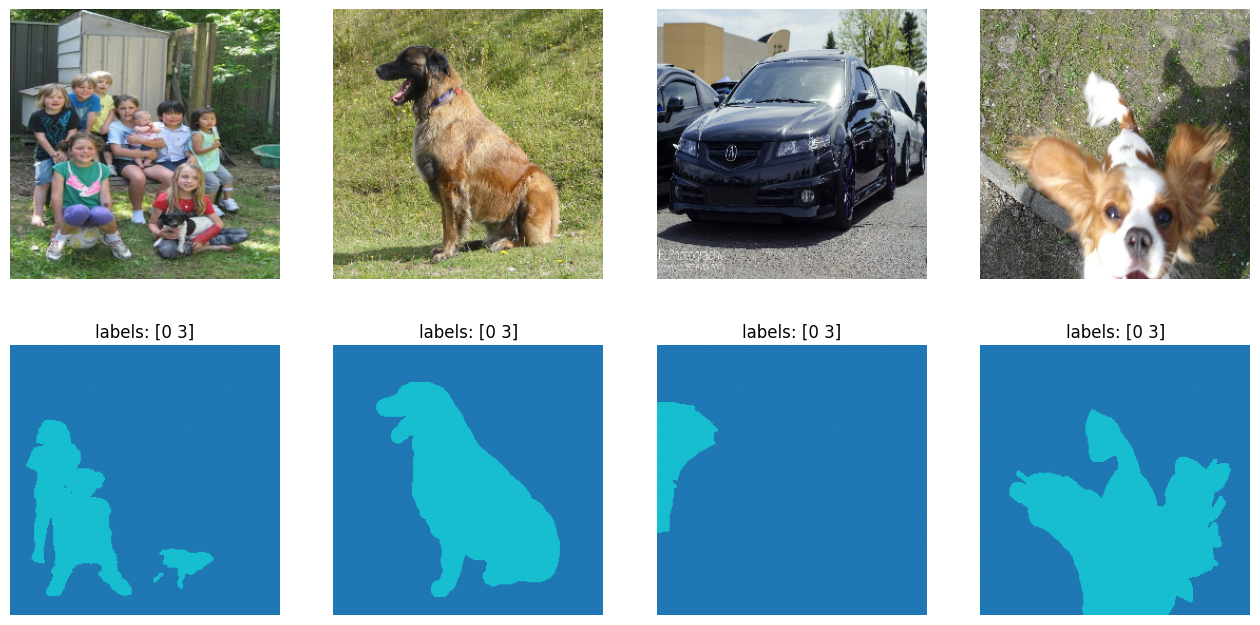

In [8]:
def show_batch(ds, n=4):
    it = iter(ds)
    try:
        images, masks = next(it)
    except StopIteration:
        print("⚠️  Dataset is empty!")
        return

    imgs_np  = images.numpy()
    masks_np = masks.numpy().squeeze(-1)

    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    for i in range(n):
        axes[0,i].imshow(imgs_np[i].astype("uint8"))
        axes[0,i].axis("off")
        axes[1,i].imshow(masks_np[i], cmap="tab10", vmin=0, vmax=3)
        axes[1,i].set_title(f"labels: {np.unique(masks_np[i])}")
        axes[1,i].axis("off")
    plt.show()

# sanity check:
show_batch(train_ds, n=4)

### U-Net Model Architecture
Custom segmentation model with skip connections:

In [9]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return layers.BatchNormalization()(x)

def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    x = layers.Rescaling(1/255.0)(inputs)  # normalize

    # Encoder
    c1 = conv_block(x, 64)
    p1 = layers.MaxPool2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPool2D()(c2)

    c3 = conv_block(p2, 256)

    # Decoder
    u2 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = conv_block(u2, 128)

    u3 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(c4)
    u3 = layers.concatenate([u3, c1])
    c5 = conv_block(u3, 64)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c5)
    return models.Model(inputs, outputs)

model = build_unet((*img_size, 3), num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    295,040 │ batch_normalizat

 Total params: 2,072,964 (7.91 MB)

 Trainable params: 2,070,404 (7.90 MB)

 Non-trainable params: 2,560 (10.00 KB)

### Training Configuration
Custom metrics and loss for segmentation:

In [10]:
def dice_coeff(y_true, y_pred):
    y_true = tf.one_hot(tf.squeeze(y_true, axis=-1), num_classes)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), num_classes)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection) / (union + 1e-7)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[dice_coeff, "accuracy"]
)

In [11]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=callbacks,
)

2025-04-26 21:16:32.091400: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 134217728 exceeds 10% of free system memory.
2025-04-26 21:16:32.144451: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 134217728 exceeds 10% of free system memory.
2025-04-26 21:16:32.176209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 134217728 exceeds 10% of free system memory.
2025-04-26 21:16:32.204503: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 134217728 exceeds 10% of free system memory.
2025-04-26 21:16:32.292257: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 134217728 exceeds 10% of free system memory.


71/71 ━━━━━━━━━━━━━━━━━━━━ 432s 6s/step - accuracy: 0.4840 - dice_coeff: 0.4841 - loss: 1.4007 - val_accuracy: 0.7879 - val_dice_coeff: 0.7966 - val_loss: 0.9156 - learning_rate: 0.0010


### Training Visualization
Plot loss and metrics:

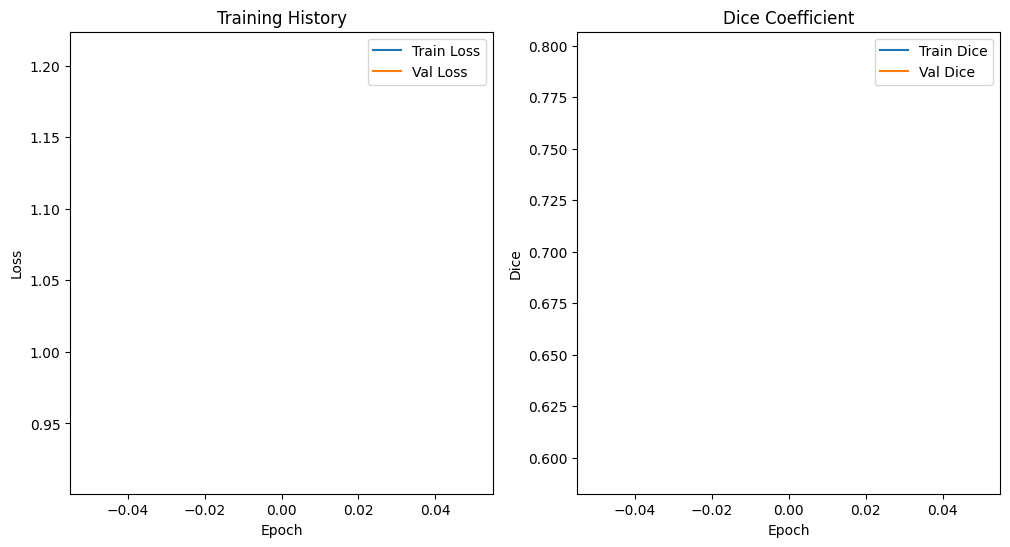

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coeff'], label='Train Dice')
plt.plot(history.history['val_dice_coeff'], label='Val Dice')
plt.title('Dice Coefficient')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Evaluation Metrics
Calculate required statistics:

In [13]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    
    return cm, precision, recall, accuracy, micro_f1, macro_f1

# Generate predictions
y_true = []
y_pred = []

for images, masks in test_ds:
    preds = model.predict(images)
    y_true.extend(masks.numpy().flatten())
    y_pred.extend(np.argmax(preds, axis=-1).flatten())

# Calculate metrics
cm, prec, rec, acc, f1_micro, f1_macro = calculate_metrics(np.array(y_true), np.array(y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


2025-04-26 21:23:58.741692: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Results Visualization
Display metrics and confusion matrix:


Segmentation Metrics:
Accuracy: 0.7560
Precision: 0.6009
Recall: 0.7560
Micro F1: 0.7560
Macro F1: 0.2154


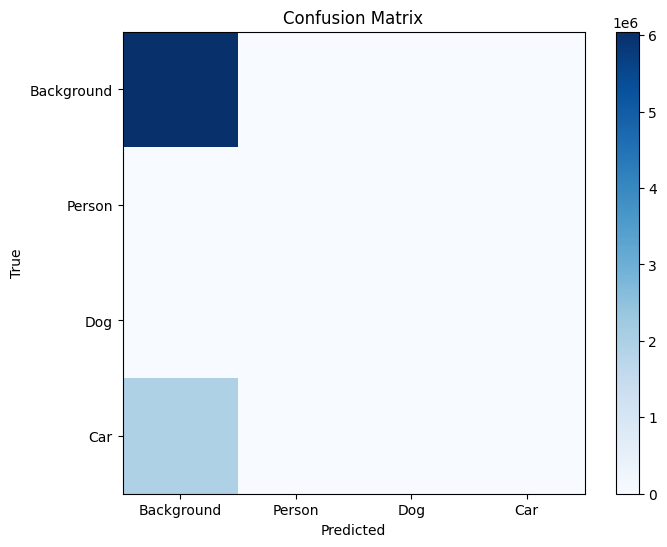

In [14]:
print(f"\nSegmentation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Micro F1: {f1_micro:.4f}")
print(f"Macro F1: {f1_macro:.4f}")

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
# Add "Background" class to match num_classes
classes_with_background = ["Background"] + classes
plt.xticks(range(num_classes), classes_with_background)
plt.yticks(range(num_classes), classes_with_background)
plt.show()

### FiftyOne Visualization
Interactive result analysis:

In [15]:
session = fo.launch_app(test_v)

# 1) Make your mask‐targets mapping with string keys
mask_targets = {
    "0": "background",
    "1": "Person",
    "2": "Dog",
    "3": "Car",
}

# 2) Attach your predictions, passing in the string‐keyed map
for sample in test_v:
    img = tf.keras.utils.load_img(sample.filepath, target_size=img_size)
    arr = tf.keras.utils.img_to_array(img) / 255.0

    pred = model.predict(np.expand_dims(arr, 0))[0]
    mask = np.argmax(pred, axis=-1).astype(np.uint8)
    print("Unique labels in prediction:", np.unique(mask))

    sample["prediction"] = fo.Segmentation(
        mask=mask,
        mask_targets=mask_targets,
    )
    sample.save()

# 3) Refresh the App view
session.view = test_v

session.wait()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Unique labels in prediction: [0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Unique labels in predicti

Notebook sessions cannot wait


In [39]:
# ── 1) Dataset pipeline (per the TF tutorial) ────────────────────────────────
def load_image_and_mask(image_path, mask_path):
    # load & preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # load & preprocess mask
    m = tf.io.read_file(mask_path)
    m = tf.image.decode_png(m, channels=1)
    m = tf.image.resize(m, IMG_SIZE, method="nearest")
    m = tf.cast(m, tf.int32)
    # clamp everything ≥NUM_CLASSES to 0
    m = tf.where(m < NUM_CLASSES, m, 0)
    # squeeze to [H,W] so loss sees shape [B,H,W]
    m = tf.squeeze(m, axis=-1)

    return img, m

def make_ds(split, shuffle=True):
    img_dir  = os.path.join(dataset_dir, split, "data")
    mask_dir = os.path.join(dataset_dir, split, "labels")

    # 1) deterministically list images
    img_paths = sorted(glob.glob(f"{img_dir}/*.jpg"))
    # 2) build mask_paths one-to-one by filename
    mask_paths = [
        os.path.join(mask_dir, os.path.basename(p).rsplit(".",1)[0] + ".png")
        for p in img_paths
    ]

    # sanity check
    if len(img_paths) == 0:
        raise ValueError(f"No images found in {img_dir}")
    if any(not os.path.exists(m) for m in mask_paths):
        missing = [m for m in mask_paths if not os.path.exists(m)]
        raise FileNotFoundError(f"Masks missing for images:\n{missing[:5]}...")

    # 3) build tf.data pipeline
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.cache().shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds("train", shuffle=True)
val_ds   = make_ds("val",   shuffle=False)
test_ds  = make_ds("test",  shuffle=False)


In [40]:
# ── 2) Model definition with pretrained MobileNetV2 encoder ───────────────────
def upsample_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet_mobilenet(input_shape=(256,256,3), num_classes=NUM_CLASSES):
    # use the TF tutorial's MobileNetV2 as down-stack
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights="imagenet")
    layer_names = [
        "block_1_expand_relu",   # 128x128
        "block_3_expand_relu",   #  64x64
        "block_6_expand_relu",   #  32x32
        "block_13_expand_relu",  #  16x16
        "block_16_project",      #   8x8
    ]
    down_stack = [base_model.get_layer(name).output for name in layer_names]
    down_model = keras.Model(inputs=base_model.input, outputs=down_stack)
    down_model.trainable = False  # freeze

    inputs = layers.Input(shape=input_shape)
    skips = down_model(inputs)
    x = skips[-1]
    s1, s2, s3, s4 = skips[0], skips[1], skips[2], skips[3]

    # decoder / upsampling
    x = upsample_block(x, s4, 512)  # 8→16
    x = upsample_block(x, s3, 256)  # 16→32
    x = upsample_block(x, s2, 128)  # 32→64
    x = upsample_block(x, s1,  64)  # 64→128

    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)  # 128→256
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    # final prediction layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_unet_mobilenet()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.summary()


/tmp/ipykernel_34151/3422087004.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ [(None, 128, 128, │  1,841,984 │ input_layer_8[0]… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 16, 16,    │  1,475,072 │ functional_7[0][… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ functional_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │  5,014,016 │ concatenate_14[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_41[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_18 │ (None, 32, 32,    │  1,179,904 │ conv2d_42[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ functional_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │  1,032,448 │ concatenate_15[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_43[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 64, 64,    │    295,040 │ conv2d_44[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │    313,472 │ concatenate_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_45[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_20 │ (None, 128, 128,  │     73,792 │ conv2d_46[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                 

 Total params: 14,480,196 (55.24 MB)

 Trainable params: 12,638,212 (48.21 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [ ]:
import numpy as np

for images, masks in train_ds.take(1):
    for i, mask in enumerate(masks.numpy()):
        print(f"Sample {i} labels:", np.unique(mask))
    break


Sample 0 labels: [0]
Sample 1 labels: [0]
Sample 2 labels: [0]
Sample 3 labels: [0]
Sample 4 labels: [0]
Sample 5 labels: [0]
Sample 6 labels: [0]
Sample 7 labels: [0]


In [42]:
# ── 3) Training (mirror tutorial) ─────────────────────────────────────────────
EPOCHS = 1
# compute steps if you want exact epochs
steps_per_epoch = len(glob.glob("./content/train/data/*.jpg")) // BATCH_SIZE

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
)


70/70 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6666 - loss: 0.6436 - val_accuracy: 1.0000 - val_loss: 5.6829e-05


In [43]:
# ── 4) Visualization & evaluation ────────────────────────────────────────────
# show a few predictions per the TF tutorial
import matplotlib.pyplot as plt
import numpy as np

def display_sample(model, ds, num=3):
    for images, masks in ds.take(1):
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1)
        masks = masks.numpy().squeeze(-1)
        break

    fig, axs = plt.subplots(num, 3, figsize=(12, 4*num))
    for i in range(num):
        axs[i,0].imshow(images[i])
        axs[i,0].set_title("Input image")
        axs[i,1].imshow(masks[i], cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
        axs[i,1].set_title("True mask")
        axs[i,2].imshow(preds[i], cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
        axs[i,2].set_title("Predicted mask")
    plt.tight_layout()
    plt.show()

display_sample(model, test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: cannot select an axis to squeeze out which has size not equal to one